# Learning Cost Function for Optimal Transport

From https://arxiv.org/pdf/2002.09650.pdf

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ot
from typing import Callable
from rich.progress import track

from floOTflix.models import MFModel

2022-10-07 09:10:03.167124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CLIDIOT (Cost Learning in Discrete Inverse OT) Algorithm


10 12 9 torch.Size([12, 9])
torch.Size([12, 10]) torch.Size([9, 10])
1.9127516746520996 1124.421875 3.0430335998535156
1.124784231185913 704.2093505859375 2.4550652503967285
0.3407881259918213 384.7904052734375 1.8670969009399414
0.19789159297943115 173.5919189453125 1.2991029024124146
-0.4289841651916504 151.05006408691406 1.2336974143981934
-0.8323969841003418 130.90916442871094 1.1804025173187256
-1.0612468719482422 120.40129089355469 1.1632521152496338
-1.2620580196380615 110.9971694946289 1.1442017555236816
-1.467980146408081 102.0067138671875 1.1179625988006592
-1.6824092864990234 93.35344696044922 1.0837931632995605
-1.9007271528244019 85.15621948242188 1.042244553565979
-1.6966724395751953 77.9742431640625 0.9977298378944397
-2.2448794841766357 83.41786193847656 1.0594770908355713
-2.3687665462493896 89.20297241210938 1.1099259853363037
-0.058483242988586426 94.89955139160156 1.1503256559371948
-2.510286331176758 128.6595001220703 1.2988592386245728
-2.5333640575408936 169.3519

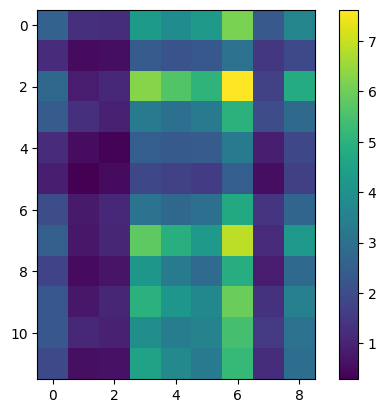

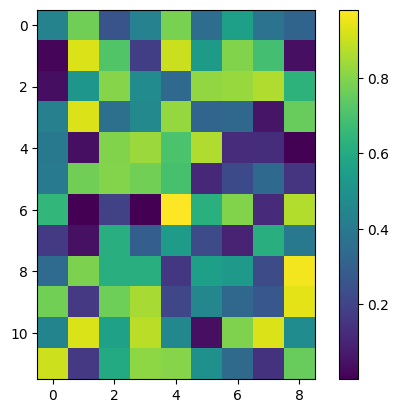

In [130]:

from cmath import pi


def CLIDIOT(pi_sample, prox_fn: Callable[[torch.TensorType], torch.TensorType], c0, eps=1e-1, max_iter=100, delta=1e-2):
    m, n = pi_sample.shape
    mu, nu = pi_sample @ torch.ones(m, 1), pi_sample.T @ torch.ones(n, 1)
    alpha, beta = torch.ones((m,1)), torch.ones((n,1))
    u, v = torch.exp(alpha / eps), torch.exp(beta / eps)
    c = c0
    print('C0', c0)
    K = torch.exp(-c0 / eps) # TODO: rm
    for _ in range(max_iter):
    # for _ in track(range(max_iter), description='CLIDIOT'):
        # K = torch.exp(-c / eps)
        u = mu / (K @ v)
        v = nu / (K.T @ u)
        K = pi_sample / (u @ v.T)
        # c_next = prox_fn(K)
        # print('K', K)
        # print('uv', [float(x) for x in u], [float(x) for x in v])
        # if torch.norm(c_next - c) < delta:
        #     break
        # c = c_next
    return c

def CLIDIOT_pure(pi_sample, eps=1e-1, max_iter=100, delta=1e-6):
    def prox_fn(K):
        return -eps * torch.log(K)
    m, n = pi_sample.shape
    c0 = torch.ones((m,n)) - torch.eye(m)
    return CLIDIOT(pi_sample, prox_fn, c0, eps, max_iter, delta)

def CLIDIOT_symmetric(pi_sample, eps=1e-1, max_iter=100, delta=1e-6):
    def prox_fn(K):
        c_hat = -eps * torch.log(K)
        return (c_hat + c_hat.t())/2

    m, n = pi_sample.shape
    c0 = torch.ones((m,n)) - torch.eye(m)
    return CLIDIOT(pi_sample, prox_fn, c0, eps, max_iter, delta)

def CLIDIOT_affinity(pi_sample, U, V, eps=1e-1, max_iter=100, delta=1e-6):
    U_inv = torch.linalg.pinv(U)
    V_inv = torch.linalg.pinv(V)

    def prox_fn(K):
        return -eps * U.t() @ U_inv.t()@torch.log(K)@V_inv @ V

    m, n = pi_sample.shape
    p, q = U.shape[0], V.shape[0]
    a0 = torch.ones((p,q))
    c0 = U.t().mm(a0).mm(V)
    return CLIDIOT(pi_sample, prox_fn, c0, eps, max_iter, delta)

def CLIDIOT_affinity(pi_sample, U, V, eps=1e-2, max_iter=100, opti='adam', lr=1e-1):
    _, k = U.shape
    m, n = pi_sample.shape
    print(k, m, n, pi_sample.shape)
    print(U.shape, V.shape)
    mu, nu = pi_sample @ torch.ones(n, 1), pi_sample.T @ torch.ones(m, 1)
    alpha, beta = torch.rand((m,1), requires_grad=True), torch.rand((n,1), requires_grad=True)
    A = torch.rand((k, k), requires_grad=True)
    vars = [alpha, beta, A]
    if opti == 'sgd':
        optimizer = torch.optim.SGD(vars, lr=lr)
    elif opti == 'adam':
        optimizer = torch.optim.Adam(vars, lr=lr)
    else:
        assert False, f"Optimizer {opti} doesn't exists"
    
    for _ in range(max_iter):
        optimizer.zero_grad()
        C = U @ A @ V.T
        loss = (eps * torch.exp(
            alpha.expand(m, n) + beta.T.expand(m, n) - C / eps
        ).sum() - alpha.T @ mu - beta.T @ nu + (C * pi_sample).sum()).view((1,))
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            C[:] = C.clamp(min=0)
        print(float(loss), float(((C-C_truth)**2).sum()), float((C * pi_sample).sum()))
    return C

C_pred = CLIDIOT_affinity(pi_sample, U, V, max_iter=30)
plt.imshow(C_pred.detach().numpy());plt.colorbar();plt.show()
plt.imshow(C_truth.detach().numpy());plt.colorbar();plt.show()

# Toy Dataset

To build a toy dataset, we create $r \in R^m$ and $c \in R^n$ two random marginal distribution and let $C_{truth} \in [0, 1]^{m,n}$ be a random cost matrix.

In [112]:
p = 1
m, n = 12, 9

# create random marginal distributions
r = 1 + torch.rand(m)
c = 1 + torch.rand(n)

r /= torch.sum(r)
c /= torch.sum(c)

# create random cost matrix
C_truth = torch.rand(m, n)

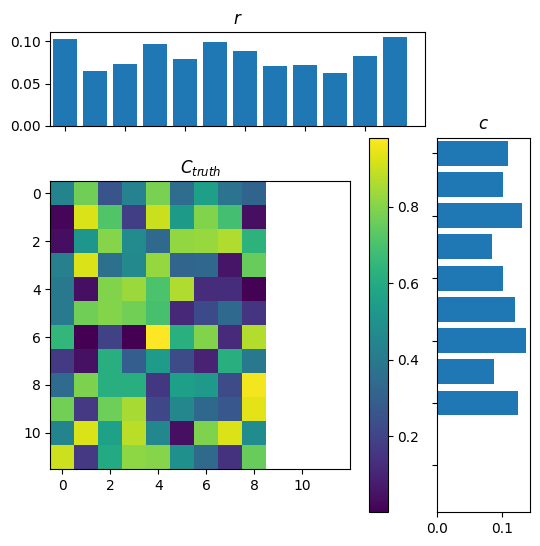

In [113]:
# from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,
    width_ratios=(4, 1), height_ratios=(1, 4), left=0.1,
    right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)


sp = ax.imshow(C_truth)
fig.colorbar(sp, ax=ax)
ax.set_title('$C_{truth}$')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.bar(np.arange(m), r)
ax_histx.set_title('$r$')

ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.barh(np.arange(n), c)
ax_histy.set_title('$c$')

plt.show()

In [114]:
eps = 1e-2
pi_sample = ot.sinkhorn(r, c, C_truth, reg=eps)
pi_sample /= pi_sample.sum()

/usr/local/anaconda3/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


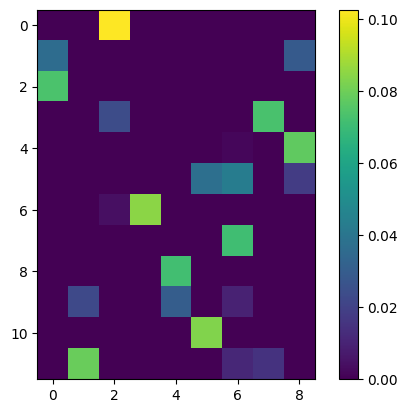

In [115]:
plt.imshow(pi_sample)
plt.colorbar()
plt.show()

In [122]:
k = 10
N_train = 20
N_test = 6

X_train = torch.stack([
    torch.randint(0, m, (N_train,)),
    torch.randint(0, n, (N_train,))
]).T
X_test = torch.stack([
    torch.randint(0, m, (N_test,)),
    torch.randint(0, n, (N_test,))
]).T

y_train = pi_sample[X_train[:,0], X_train[:,1]]
y_test = pi_sample[X_test[:,0], X_test[:,1]]

mf_model = MFModel(m, n, k)
mf_model.fit(X_train, y_train, X_test, y_test, n_epochs=1000)
score = mf_model.score(X_test, y_test)
print(f"MFModel score: {score}")

Output()

[15:02:36] Epoch 0, train error: 2.7102086544036865, test error: 2.1704909801483154                       ]8;id=572122;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=862372;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

[15:02:37] Epoch 100, train error: 1.8808461427688599, test error: 1.7754303216934204                     ]8;id=610042;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=576126;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 200, train error: 1.2752046585083008, test error: 1.4598114490509033                     ]8;id=906392;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=222774;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 300, train error: 0.8315525650978088, test error: 1.2095195055007935                     ]8;id=208059;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=198667;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 400, train error: 0.5109273791313171, test error: 1.0152589082717896                     ]8;id=550857;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=899753;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 600, train error: 0.14976418018341064, test error: 0.7640177011489868                    ]8;id=674693;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=32610;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 700, train error: 0.06953991949558258, test error: 0.6831672787666321                    ]8;id=676863;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=578494;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 800, train error: 0.014430965296924114, test error: 0.6166811585426331                   ]8;id=56010;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=808932;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

           Epoch 900, train error: 0.0008768917177803814, test error: 0.584190309047699                   ]8;id=535347;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py\mf.py]8;;\:]8;id=367551;file:///Users/webalorn/Documents/ens/cours/a3s1/projet-science-des-données/assignment1/_repo/floOTflix/models/mf.py#126\126]8;;\

MFModel score: 0.5612331628799438


In [123]:
U, V = mf_model.U, mf_model.V
print(f'U: {U.shape} V: {V.shape}')

U: torch.Size([12, 10]) V: torch.Size([9, 10])


In [88]:
C_pred = CLIDIOT_affinity(pi_sample, U.t(), V.t(), delta=10e-6)

TypeError: CLIDIOT_affinity() got an unexpected keyword argument 'delta'

In [89]:
plt.imshow(C_star)
plt.colorbar()
plt.title('$C^*$')
plt.show()

NameError: name 'C_star' is not defined

In [55]:
torch.randint(0, m, (10,2))

tensor([[1, 3],
        [3, 1],
        [3, 4],
        [3, 0],
        [1, 1],
        [1, 1],
        [1, 4],
        [4, 4],
        [2, 3],
        [1, 2]])